# NASA Bearing dataset

[kaggle](https://www.kaggle.com/vinayak123tyagi/bearing-dataset), [repo](https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/)

4 Rolamentos instalados em um eixo. Amostras de 1s de duração com frequência de amostragem Fs=20kHz, totalizando 20.480 amostras por sequência de coleta. Dividido em 3 datasets:

### Set 1:
- 2.156 exemplos
- 2x acelerômetros uniaxiais [x,y] por rolamento

Description: At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller

### Set 2:
- 948 exemplos
- 1x acelerômetro uniaxial por rolamento

Description: At the end of the test-to-failure experiment, outer race failure occurred in bearing 1.

### Set 3:
- 4.448 exemplos
- 1x acelerômetro uniaxial por rolamento
- Possíveis problemas nos dados

Description: At the end of the test-to-failure experiment, outer race failure occurred in bearing 3.

---

## Objetivos:
Nesse notebook, trabalharemos com o Set 2, contendo 948 sequências de dados. Nesse Set, os testes foram interrompidos devido a falha no rolamento 1.

Possíveis objetivos de análise:

- Detecção de Anomalia
- Predição de Remaining Useful Life (RUL).


## 1. Download dos dados:

Para execução do notebook completo, incluindo a seção de extração de features, é necessário o download do dataset, realizado abaixo.

Para pular a extração dos features e geração do dataset, execute as células a partir da [Seção 3](https://colab.research.google.com/drive/1WNuRbj3DT6DZdJukUbVE7NbF_Kpp6u-D#scrollTo=szmF_iwCzW25&line=4&uniqifier=1).

In [ ]:
!wget -O data.7z https://ti.arc.nasa.gov/c/3/

--2021-07-12 18:22:03--  https://ti.arc.nasa.gov/c/3/
Resolving ti.arc.nasa.gov (ti.arc.nasa.gov)... 128.102.105.66, 2001:4d0:6311:2227:14b6:372b:2078:2a94
Connecting to ti.arc.nasa.gov (ti.arc.nasa.gov)|128.102.105.66|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z [following]
--2021-07-12 18:22:04--  https://ti.arc.nasa.gov/m/project/prognostic-repository/IMS.7z
Reusing existing connection to ti.arc.nasa.gov:443.
HTTP request sent, awaiting response... 200 OK
Length: 1075320408 (1.0G) [application/x-7z-compressed]
Saving to: ‘data.7z’

data.7z             100%[===================>]   1.00G  76.8MB/s    in 14s     

2021-07-12 18:22:18 (73.3 MB/s) - ‘data.7z’ saved [1075320408/1075320408]



Extract 7zip file. The file dir contains compressed files for each of the 3 tests.

In [ ]:
!7z x ./data.7z
!unrar e 2nd_test.rar ./2nd_test/

## 2. Extração de Features:

Carregar cada sequência de dados do dataset 2 coletada durante 1s e gerar um dataset com métricas de cada sequência. 

In [ ]:
import pandas as pd
import numpy as np
import os
import itertools
import seaborn as sns
sns.set()

Os dados foram amostrados por acelerômetros com frequência de amostragem Fs = 20.48 kHz, de maneira que cada sequência de 1s é constitúida por 20.480 amostras. 
Portanto, cada um dos 948 arquivos .csv no diretório '2nd_test' possui 20.480 linhas. 

Visto que o intervalo de amostragem de 1s pode ser considerado curto, optamos por transformar cada uma das sequências de 20.480 valores são resumidas para métricas em valores escalares.

Utilizamos a média (mean), desvio padrão (std), distorção (skewness), curtose (kurtosis) e valor RMS.
Essas métricas são posteriormente agrupadas em um DataFrame para constituir o dataset.

In [ ]:
file_dir = './2nd_test'
file_list = os.listdir(file_dir)

columns_csv = ['Bearing_1','Bearing_2','Bearing_3','Bearing_4'] # nomear as colunas dos csv's originais
metric_names = ['mean','std','skew','kurt','rms'] # metricas a serem obtidas
columns_dataset = [col+'_'+met for col,met in itertools.product(columns_csv,metric_names)] # gerar nomes das novas colunas a partir dos IDs dos rolamentos e métricas

sequence_list = []
for file_ in file_list: # iterar o diretório do Set 2
    sequence = pd.read_csv(file_dir+'/'+file_,sep='\t',names=columns_csv) # leitura do csv
    
    # computar as métricas
    sequence_mean = np.array(sequence.abs().mean())
    sequence_std = np.array(sequence.std())
    sequence_skew = np.array(sequence.skew())
    sequence_kurt = np.array(sequence.kurtosis())
    sequence_rms = np.sqrt(np.mean(sequence**2))
    
    sequence_cat = np.stack((sequence_mean,sequence_std,sequence_skew,
                            sequence_kurt,sequence_rms),axis=1).reshape(1,20)

    sequence_list.append(sequence_cat.squeeze())


In [ ]:
# agrupar as métricas no formato de  DataFrame
dataset = pd.DataFrame(np.array(sequence_list),columns=columns_dataset)
dataset.index = pd.to_datetime(file_list, format='%Y.%m.%d.%H.%M.%S')
dataset = dataset.sort_index()
dataset.index.name = 'Datetime'
dataset.head()

,Bearing_1_mean,Bearing_1_std,Bearing_1_skew,Bearing_1_kurt,Bearing_1_rms,Bearing_2_mean,Bearing_2_std,Bearing_2_skew,Bearing_2_kurt,Bearing_2_rms,Bearing_3_mean,Bearing_3_std,Bearing_3_skew,Bearing_3_kurt,Bearing_3_rms,Bearing_4_mean,Bearing_4_std,Bearing_4_skew,Bearing_4_kurt,Bearing_4_rms
Datetime,,,,,,,,,,,,,,,,,,,,
2004-02-12 10:32:39,0.058332,0.073477,0.084000,0.629209,0.074179,0.071832,0.090056,0.126924,0.507217,0.090944,0.083244,0.108436,0.204855,3.214152,0.109404,0.043065,0.053168,-0.022082,0.066268,0.054103
2004-02-12 10:42:39,0.058997,0.075340,0.052146,0.648742,0.075382,0.074008,0.093386,0.070094,0.253369,0.093419,0.084439,0.109792,-0.023855,1.395884,0.109817,0.044540,0.055974,0.001583,0.107859,0.056101
2004-02-12 10:52:39,0.060239,0.076191,0.032810,0.513894,0.076230,0.074223,0.093705,0.096590,0.311158,0.093718,0.083922,0.109852,0.056565,2.640886,0.109861,0.044442,0.056038,0.070454,0.257592,0.056145
2004-02-12 11:02:39,0.061453,0.078693,0.041489,1.158529,0.078724,0.073843,0.092919,0.105842,0.235691,0.092947,0.084462,0.110624,0.033553,2.683727,0.110667,0.045081,0.056686,-0.036330,0.806680,0.056807
2004-02-12 11:12:39,0.061361,0.078439,0.028226,0.603617,0.078474,0.075606,0.095338,0.097973,0.226657,0.095348,0.082837,0.107502,-0.002892,1.579073,0.107506,0.045118,0.056778,0.019009,0.139281,0.056841


Em seguida, geramos visualizações das séries temporais de cada uma das métricas computadas. 
Como as amostras são muito breves, existe pouca variação nos dados obtidos, fato representado pelo sinal de desvio padrão semelhante à média.
É possível observar que o Bearing 1 apresenta maiores distorções em seu comportamento, o que afeta os sinais dos demais rolamentos:

[Text(0, 0.5, 'Acceleration (RMS)'), Text(0.5, 0, 'Datetime')]

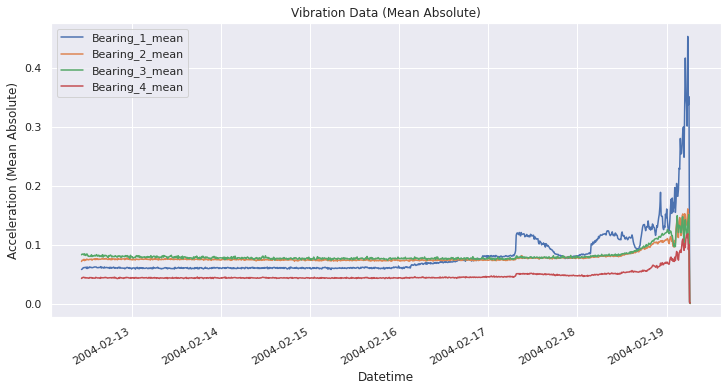

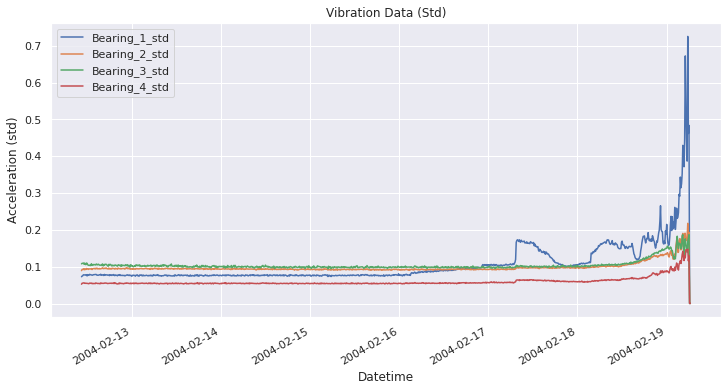

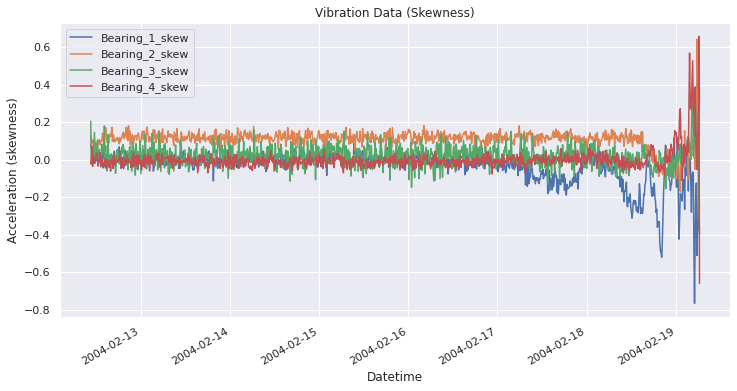

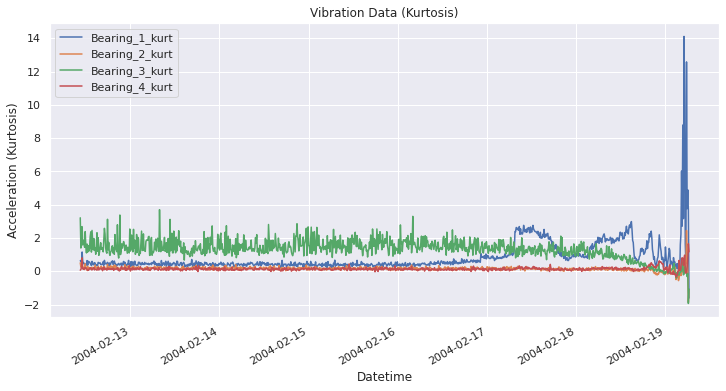

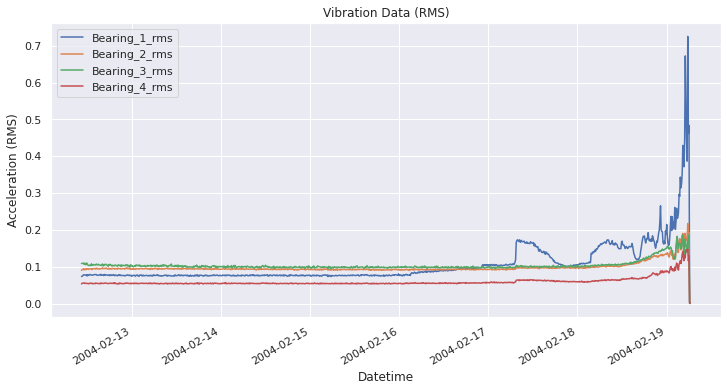

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
rcParams.update({'font.size': 14})

ax1 = dataset.loc[:,dataset.columns.str.contains('mean')].plot(figsize = (12,6), grid=True, title="Vibration Data (Mean Absolute)")
ax1.set(xlabel="Datetime", ylabel="Acceleration (Mean Absolute)")

ax2 = dataset.loc[:,dataset.columns.str.contains('std')].plot(figsize = (12,6), grid=True, title="Vibration Data (Std)")
ax2.set(xlabel="Datetime", ylabel="Acceleration (std)")

ax3 = dataset.loc[:,dataset.columns.str.contains('skew')].plot(figsize = (12,6), grid=True, title="Vibration Data (Skewness)")
ax3.set(xlabel="Datetime", ylabel="Acceleration (skewness)")

ax4 = dataset.loc[:,dataset.columns.str.contains('kurt')].plot(figsize = (12,6), grid=True, title="Vibration Data (Kurtosis)")
ax4.set(xlabel="Datetime", ylabel="Acceleration (Kurtosis)")

ax5 = dataset.loc[:,dataset.columns.str.contains('rms')].plot(figsize = (12,6), grid=True, title="Vibration Data (RMS)")
ax5.set(xlabel="Datetime", ylabel="Acceleration (RMS)")

O Rolamento 1 começa a apresentar oscilações no comportamento aproximadamento a partir da sequência número 650. Aqui, visualizamos seu comportamento nessa faixa de tempo:

[Text(0, 0.5, 'Acceleration (mean)'), Text(0.5, 0, 'Datetime')]

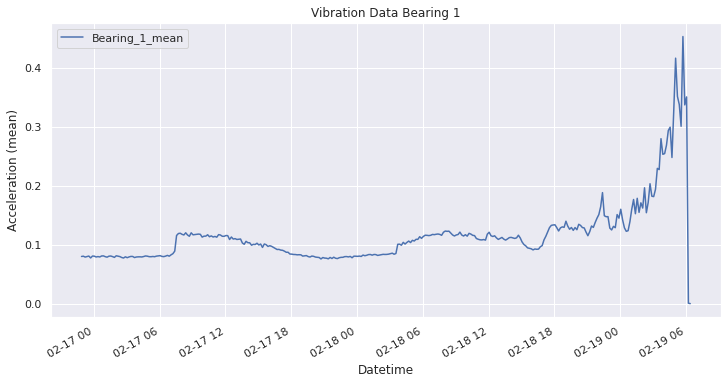

In [ ]:
ax = dataset[['Bearing_1_mean']][650:].plot(figsize = (12,6), grid=True, title="Vibration Data Bearing 1")
ax.set(xlabel="Datetime", ylabel="Acceleration (mean)")

Adicionalmente as métricas obtidas acima nos intervalos de 1s, é interessante computar métricas móveis ao longo das diferentes sequências, a fim de observar as variações do sistema ao longo de períodos maiores de tempo. 

A seguir, computamos as mesmas métricas utilizando janelas móveis de 40 minutos (4 sequências), utilizando o comando rolling da biblioteca pandas:

In [ ]:
def rms(rolling_input):
    return np.sqrt(np.mean(rolling_input**2))

rolling_window = '40T' # define window size of 40 minutes

dataset_rolling = pd.DataFrame()
for bearing in columns_csv:
    dataset_rolling['%s_%s_mean' % (bearing,rolling_window)] = dataset['%s_mean' % (bearing)].rolling(rolling_window).mean().fillna(0)
    dataset_rolling['%s_%s_std' % (bearing,rolling_window)] = dataset['%s_mean' % (bearing)].rolling(rolling_window).std().fillna(0)
    dataset_rolling['%s_%s_skew' % (bearing,rolling_window)] = dataset['%s_mean' % (bearing)].rolling(rolling_window).skew().fillna(0)
    dataset_rolling['%s_%s_kurt' % (bearing,rolling_window)] = dataset['%s_mean' % (bearing)].rolling(rolling_window).kurt().fillna(0)
    dataset_rolling['%s_%s_rms' % (bearing,rolling_window)] = dataset['%s_mean' % (bearing)].rolling(rolling_window).apply(rms).fillna(0)

[Text(0, 0.5, 'Acceleration (RMS)'), Text(0.5, 0, 'Datetime')]

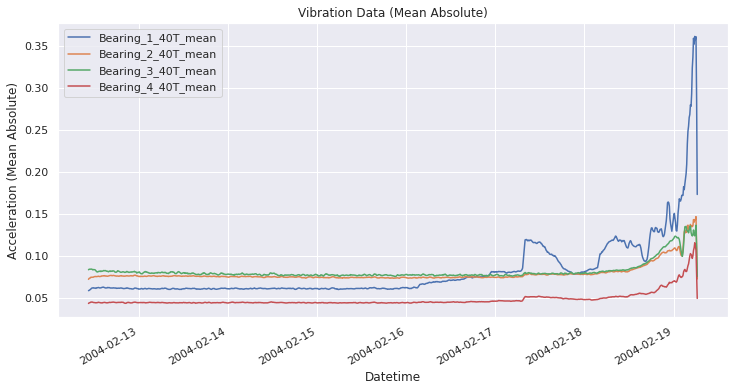

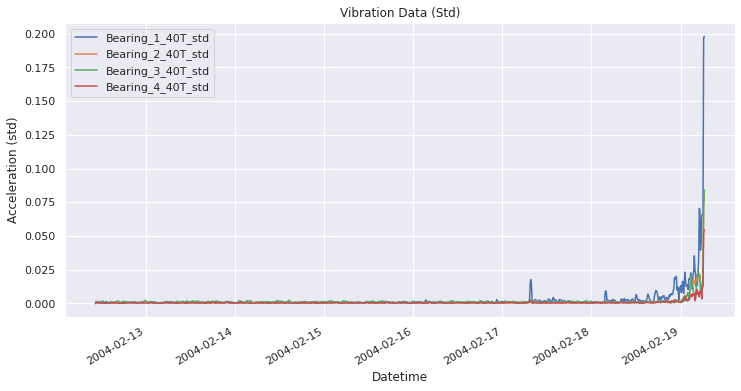

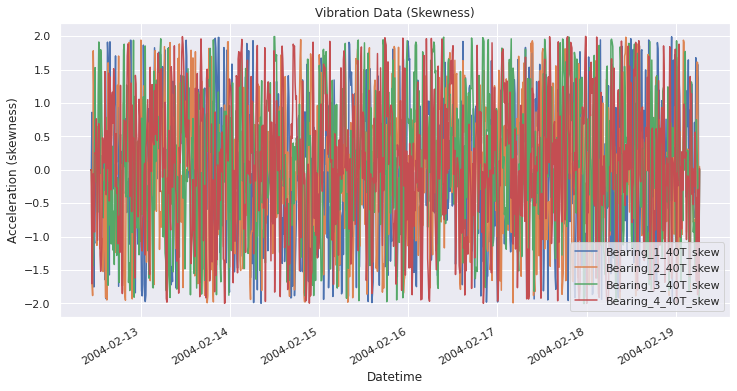

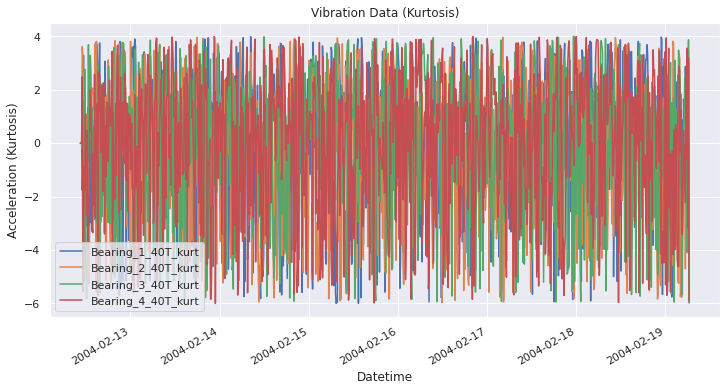

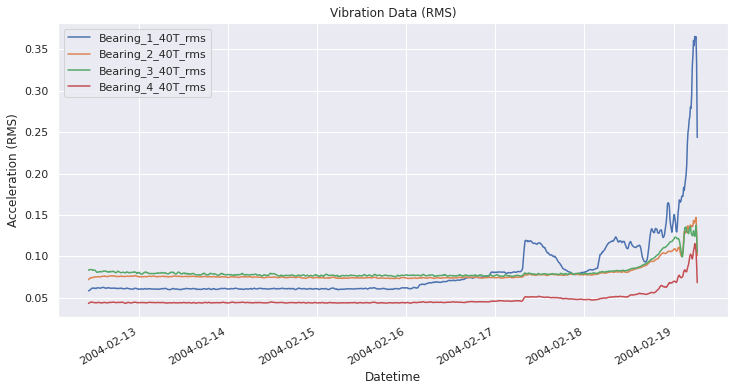

In [ ]:
ax1 = dataset_rolling.loc[:,dataset_rolling.columns.str.contains('mean')].plot(figsize = (12,6), grid=True, title="Vibration Data (Mean Absolute)")
ax1.set(xlabel="Datetime", ylabel="Acceleration (Mean Absolute)")

ax2 = dataset_rolling.loc[:,dataset_rolling.columns.str.contains('std')].plot(figsize = (12,6), grid=True, title="Vibration Data (Std)")
ax2.set(xlabel="Datetime", ylabel="Acceleration (std)")

ax3 = dataset_rolling.loc[:,dataset_rolling.columns.str.contains('skew')].plot(figsize = (12,6), grid=True, title="Vibration Data (Skewness)")
ax3.set(xlabel="Datetime", ylabel="Acceleration (skewness)")

ax4 = dataset_rolling.loc[:,dataset_rolling.columns.str.contains('kurt')].plot(figsize = (12,6), grid=True, title="Vibration Data (Kurtosis)")
ax4.set(xlabel="Datetime", ylabel="Acceleration (Kurtosis)")

ax5 = dataset_rolling.loc[:,dataset_rolling.columns.str.contains('rms')].plot(figsize = (12,6), grid=True, title="Vibration Data (RMS)")
ax5.set(xlabel="Datetime", ylabel="Acceleration (RMS)")

Adicionamos ao dataset apenas "mean", "std" como features, já que "skew" e "kurt" passam a apresentar comportamento ruidoso e "rms" não apresenta diferenças significativas para "mean":

In [ ]:
dataset = dataset.join(dataset_rolling.loc[:,dataset_rolling.columns.str.contains('mean')])
dataset = dataset.join(dataset_rolling.loc[:,dataset_rolling.columns.str.contains('std')])
dataset.head()

,Bearing_1_mean,Bearing_1_std,Bearing_1_skew,Bearing_1_kurt,Bearing_1_rms,Bearing_2_mean,Bearing_2_std,Bearing_2_skew,Bearing_2_kurt,Bearing_2_rms,Bearing_3_mean,Bearing_3_std,Bearing_3_skew,Bearing_3_kurt,Bearing_3_rms,Bearing_4_mean,Bearing_4_std,Bearing_4_skew,Bearing_4_kurt,Bearing_4_rms,Bearing_1_40T_mean,Bearing_2_40T_mean,Bearing_3_40T_mean,Bearing_4_40T_mean,Bearing_1_40T_std,Bearing_2_40T_std,Bearing_3_40T_std,Bearing_4_40T_std
Datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-02-12 10:32:39,0.058332,0.073477,0.084000,0.629209,0.074179,0.071832,0.090056,0.126924,0.507217,0.090944,0.083244,0.108436,0.204855,3.214152,0.109404,0.043065,0.053168,-0.022082,0.066268,0.054103,0.058332,0.071832,0.083244,0.043065,0.000000,0.000000,0.000000,0.000000
2004-02-12 10:42:39,0.058997,0.075340,0.052146,0.648742,0.075382,0.074008,0.093386,0.070094,0.253369,0.093419,0.084439,0.109792,-0.023855,1.395884,0.109817,0.044540,0.055974,0.001583,0.107859,0.056101,0.058665,0.072920,0.083842,0.043802,0.000470,0.001539,0.000845,0.001043
2004-02-12 10:52:39,0.060239,0.076191,0.032810,0.513894,0.076230,0.074223,0.093705,0.096590,0.311158,0.093718,0.083922,0.109852,0.056565,2.640886,0.109861,0.044442,0.056038,0.070454,0.257592,0.056145,0.059189,0.073354,0.083868,0.044016,0.000968,0.001323,0.000599,0.000825
2004-02-12 11:02:39,0.061453,0.078693,0.041489,1.158529,0.078724,0.073843,0.092919,0.105842,0.235691,0.092947,0.084462,0.110624,0.033553,2.683727,0.110667,0.045081,0.056686,-0.036330,0.806680,0.056807,0.059755,0.073477,0.084017,0.044282,0.001380,0.001108,0.000572,0.000859
2004-02-12 11:12:39,0.061361,0.078439,0.028226,0.603617,0.078474,0.075606,0.095338,0.097973,0.226657,0.095348,0.082837,0.107502,-0.002892,1.579073,0.107506,0.045118,0.056778,0.019009,0.139281,0.056841,0.060512,0.074420,0.083915,0.044795,0.001151,0.000806,0.000761,0.000354


In [ ]:
## save dataset
# dataset.to_csv('bearing_dataset2_proc.csv',index=True)

## 3. Análise dos dados

Para começar a partir dessa seção, importe o csv do dataset processado na célula abaixo:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdown

target_url = 'https://drive.google.com/uc?id=15vYdiRCK3dCELiIk2I0FwVMVy2CO_stm'

gdown.download(target_url,'data.csv',quiet=False)

data_proc = pd.read_csv('data.csv')
dataset = pd.DataFrame(data_proc)
dataset = dataset.set_index('Datetime')

Downloading...
From: https://drive.google.com/uc?id=15vYdiRCK3dCELiIk2I0FwVMVy2CO_stm
To: /content/data.csv
100%|██████████| 579k/579k [00:00<00:00, 4.12MB/s]


### 3.1 Feature Selection e redução de dimensionalidade:

Aplicação de PCA para redução de dimensionalidade. Se os dados não estão padronizados, a contribuição do primeiro componente fica distorcida:

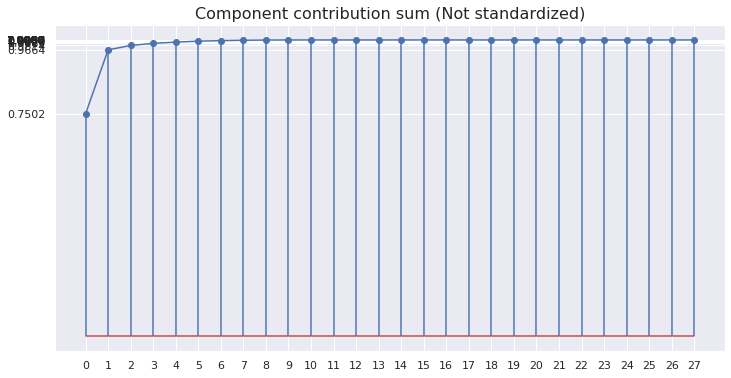

In [ ]:
from sklearn.decomposition import PCA

pca_all = PCA()
pca_all.fit_transform(dataset) 

fig = plt.figure(figsize=(12, 6))
ax = plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
ax = plt.stem(np.cumsum(pca_all.explained_variance_ratio_),use_line_collection=True)
plt.xticks(np.arange(len(pca_all.explained_variance_ratio_)))
plt.yticks(np.cumsum(pca_all.explained_variance_ratio_))
plt.title("Component contribution sum (Not standardized)",fontsize=16)
plt.grid(True)

Padronização do dataset:

In [ ]:
from sklearn.preprocessing import StandardScaler
import copy

scaler = StandardScaler()
dataset_scaled = copy.deepcopy(dataset)
dataset_scaled[dataset_scaled.columns] = scaler.fit_transform(dataset_scaled[dataset_scaled.columns])

Aplicação do PCA no dataset padronizado:

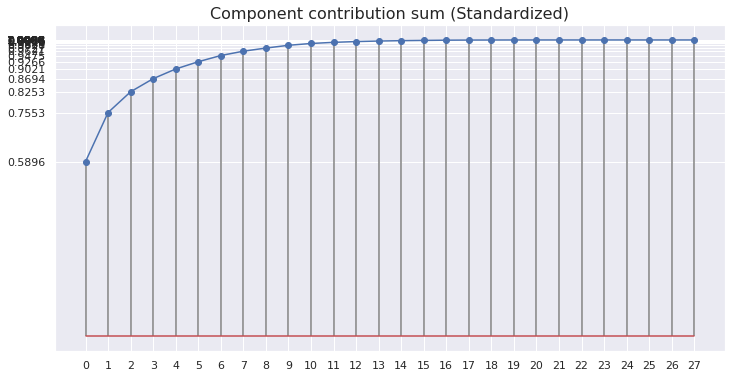

In [ ]:
from sklearn.decomposition import PCA

pca_all = PCA()
pca_all.fit_transform(dataset_scaled) 

fig = plt.figure(figsize=(12, 6))
ax= plt.plot(np.cumsum(pca_all.explained_variance_ratio_))
ax = plt.stem(np.cumsum(pca_all.explained_variance_ratio_),use_line_collection=True,linefmt='grey')
plt.xticks(np.arange(len(pca_all.explained_variance_ratio_)))
plt.yticks(np.cumsum(pca_all.explained_variance_ratio_))
plt.title("Component contribution sum (Standardized)",fontsize=16)
plt.grid(True)

Visualização dos 2 componentes principais. No segundo plot os dados são coloridos de acordo com o tempo de coleta. Sequências acima da 650, onde as anomalias começam a ocorrer, estão em laranja.

Pode-se observar que as amostras com anomalia apresentam distribuição mais esparsa na projeção em duas dimensões.

Text(0.5, 1.0, 'PCA=2 Split by time')

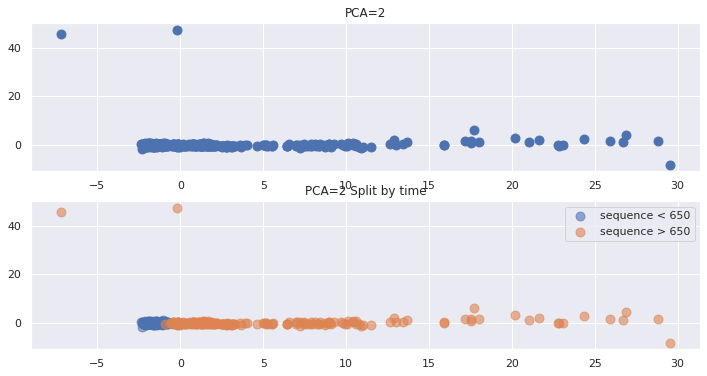

In [ ]:
dataset = dataset_scaled

pca = PCA(n_components=2)
pca_data = pca.fit_transform(dataset)

fig, (ax,ax2) = plt.subplots(2,figsize=(12, 6))
ax.scatter(pca_data[:,0],pca_data[:,1],s=80)
ax.set_title('PCA=2')
ax = plt.scatter(pca_data[:700,0],pca_data[:700,1],s=80,alpha=0.6,label='sequence < 650')
ax2.scatter(pca_data[700:,0],pca_data[700:,1],s=80,alpha=0.6,label='sequence > 650')
ax2.legend()
ax2.set_title('PCA=2 Split by time')

### 3.2 K-means Clustering:

Nessa seção, aplicamos o algoritmo K-means em diferentes splits dos dados para analisar sua capacidade de distinguir anomalias.

#### K-means prediction with random splits:

Utilizando-se splits aleatórios, perde-se a noção de temporalidade. Tanto o PCA quanto o K-means são ajustados sobre o dataset de treino, e posteriormente aplicados sobre o teste.

A avaliação dos resultados é feita a partir da atribuição de labels, dentro de cada split, de acordo com o indíce de cada sequência ( normal <= 650 < anomalia).

No caso do PCA com 2 componentes, observa-se que enquanto o PCA ajustado sobre todo o dataset é capaz de manter a diferenciação entre exemplos normais e anormais (no plot acima (PCA=2 Split by time)), o PCA ajustado sobre splits aleatórios pode perder essa informação, misturando exemplos das duas classes na representação (plot K-means True labels).

Resultados decentes podem ser obtidos, mas dependem muito da inicialização.Testar ensemble.

Acc: 0.2436548223350254| F1: 0.10778443113772455 | Precision: 0.6428571428571429 | Recall: 0.058823529411764705
1-Acc: 0.7563451776649746| 1-F1: 0.8922155688622755 | 1-Precision: 0.3571428571428571 | Recall: 0.9411764705882353


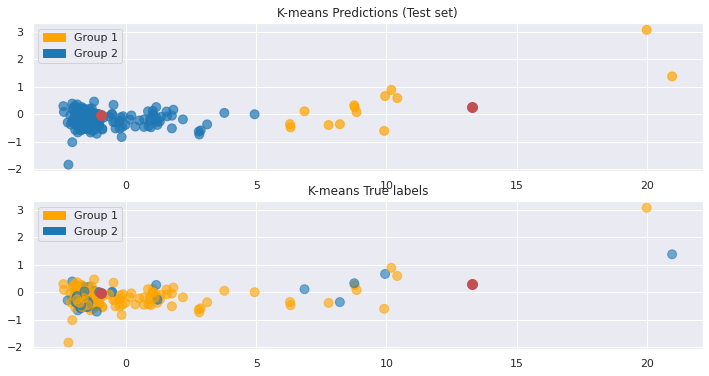

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import matplotlib.patches as mpatches

orange_patch = mpatches.Patch(color='orange', label='Group 1')
blue_patch = mpatches.Patch(color='tab:blue', label='Group 2')

split = 0.8

# reset dataset index, so that index is sequence number 0-948
dataset_ind = dataset.reset_index()
dataset_ind = dataset_ind.iloc[:,1:]
dataset_ind.index = np.arange(len(dataset_ind))

X_train, X_test = train_test_split(dataset_ind, test_size=1-split, random_state=18)

# Apply PCA
pca = PCA(n_components=2)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

# Apply K-means 
kmeans = KMeans(n_clusters=2, random_state=42,algorithm='full').fit(pca_train)
centers = kmeans.cluster_centers_
pred = kmeans.predict(pca_test)

# Evaluate predictions

# create labels
idx_normal = X_test.index[X_test.index <= 650]
idx_anomaly = X_test.index[X_test.index > 650]
true_labels = [0 if index in idx_normal else 1 for index in range(len(pca_test))]

# compute metrics
acc_kmeans_rdn = accuracy_score(true_labels,pred)
f1_kmeans_rdn = f1_score(true_labels,pred)
precision_kmeans_rdn = precision_score(true_labels,pred)
recall_kmeans_rdn = recall_score(true_labels,pred)
print("Acc: {}| F1: {} | Precision: {} | Recall: {}".format(acc_kmeans_rdn,f1_kmeans_rdn,precision_kmeans_rdn,recall_kmeans_rdn))
print("1-Acc: {}| 1-F1: {} | 1-Precision: {} | Recall: {}".format(1-acc_kmeans_rdn,1-f1_kmeans_rdn,1-precision_kmeans_rdn,1-recall_kmeans_rdn))

fig, (ax,ax2) = plt.subplots(2,figsize=(12,6))
ax.scatter(pca_test[:,0],pca_test[:,1],c=['orange' if item == 1 else 'tab:blue' for item in pred], alpha=0.7,s=80)
ax.scatter(centers[:,0],centers[:,1],c='r',s=100)
ax.legend(handles=[orange_patch,blue_patch])
ax.set_title('K-means Predictions (Test set)')

ax2.scatter(pca_test[:,0],pca_test[:,1],c=['orange' if item == 1 else 'tab:blue' for item in true_labels], alpha=0.6,s=80)
ax2.scatter(centers[:,0],centers[:,1],c='r',s=100)
ax2.set_title('K-means True labels')
ax2.legend(handles=[orange_patch,blue_patch])


#### K-Means prediction with temporal split:

Nesse caso, a predição com K-means é repetida, mas os datasets são divididos de maneira ad-hoc.

Como se sabe que o sistema começa a apresentar anomalias a partir na faixa das sequências 650~700, os exemplos são divididos em normais (sequencia <= 650) e anomalias (sequencia > 650). A seguir, o dataset de treino e teste são gerados a partir da combinação de exemplos normais e anomalias, de maneira que cada o split de treino possua 70% dos exemplos normais e 70% dos exemplos de anomalias, e o dataset de teste 30% dos exemplos normais e 30% dos exemplos de anomalias.

Esse formato de separação apresenta ótimos resultados, mas não é ideal, pois introduz fortes *bias* no modelo.

Acc: 0.9932659932659933| F1: 0.99 | Precision: 1.0 | Recall: 0.9801980198019802
1-Acc: 0.006734006734006703| 1-F1: 0.010000000000000009 | 1-Precision: 0.0 | Recall: 0.01980198019801982


Text(0.5, 1.0, 'Test set Prediction')

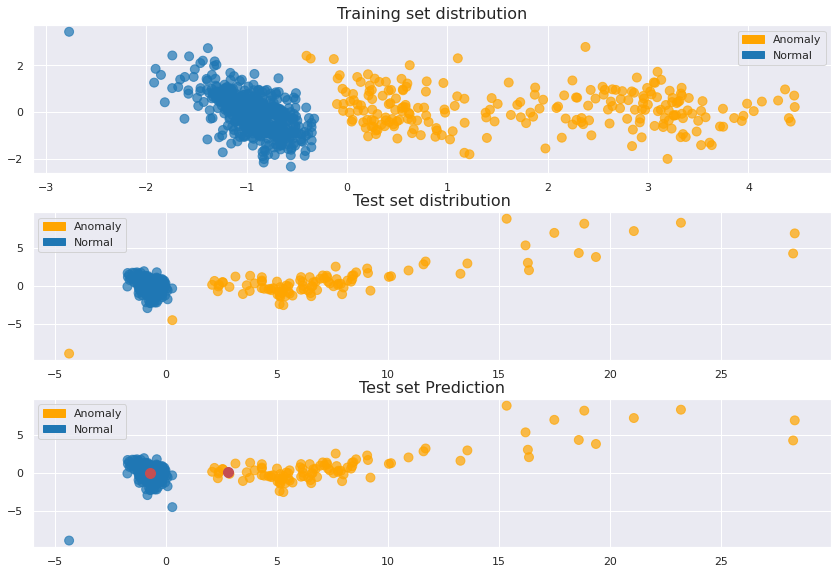

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import matplotlib.patches as mpatches

orange_patch = mpatches.Patch(color='orange', label='Anomaly')
blue_patch = mpatches.Patch(color='tab:blue', label='Normal')

# Split dataset stratifying anomaly and normal data, using anomaly as sequence>650.
normal_dataset = dataset[:650]
anomaly_dataset = dataset[650:]
split = 0.7

# Get normal and anomaly examples for each set
normal_training_idx = normal_dataset[:int(split*len(normal_dataset))]
normal_test_idx = normal_dataset[int(split*len(normal_dataset)):]
anomaly_training_idx = anomaly_dataset[:int(split*len(anomaly_dataset))]
anomaly_test_idx = anomaly_dataset[int(split*len(anomaly_dataset)):]

# Join normal and anomaly examples into each set
training_set = pd.concat([normal_training_idx,anomaly_training_idx])
training_labels = [0]*len(normal_training_idx) + [1]*len(anomaly_training_idx)
test_set = pd.concat([normal_test_idx,anomaly_test_idx])
test_labels = [0]*len(normal_test_idx) + [1]*len(anomaly_test_idx)

# Apply PCA
pca = PCA(n_components=2)
pca_train = pca.fit_transform(training_set)
pca_test = pca.transform(test_set)

# Fit K-means model and perform predictions
kmeans_adhoc = KMeans(n_clusters=2, random_state=0, algorithm='full').fit(pca_train)
centers = kmeans_adhoc.cluster_centers_
pred = kmeans_adhoc.predict(pca_test)

# Evaluate results. Results can be inverted if k-means predicted inverted labels
acc_kmeans_adhoc = accuracy_score(test_labels,pred)
f1_kmeans_adhoc = f1_score(test_labels,pred)
precision_kmeans_adhoc = precision_score(test_labels,pred)
recall_kmeans_adhoc = recall_score(test_labels,pred)
print("Acc: {}| F1: {} | Precision: {} | Recall: {}".format(acc_kmeans_adhoc,f1_kmeans_adhoc,precision_kmeans_adhoc,recall_kmeans_adhoc))
print("1-Acc: {}| 1-F1: {} | 1-Precision: {} | Recall: {}".format(1-acc_kmeans_adhoc,1-f1_kmeans_adhoc,1-precision_kmeans_adhoc,1-recall_kmeans_adhoc))

# Plot results
fig, (ax,ax2,ax3) = plt.subplots(3,figsize=(12, 8))
fig.tight_layout()
ax.scatter(pca_train[:,0],pca_train[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in training_labels], alpha=0.7)
ax.legend(handles=[orange_patch,blue_patch])
ax.set_title("Training set distribution",fontsize=16)

ax2.scatter(pca_test[:,0],pca_test[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in test_labels], alpha=0.7)
ax2.legend(handles=[orange_patch,blue_patch])
ax2.set_title("Test set distribution",fontsize=16)

ax3.scatter(pca_test[:,0],pca_test[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in pred], alpha=0.7)
ax3.scatter(centers[:,0],centers[:,1],c='r',s=100)
ax3.legend(handles=[orange_patch,blue_patch])
ax3.set_title("Test set Prediction",fontsize=16)

## Isolation Forest

Classificador para detecção de anomalia, adaptação do Random Forests para isolar exemplos. Executa particionamento do dataset de maneira recursiva. Quanto menor o número de splits necessários para isolar um determinado exemplo, maior a chance de ele ser um outlier.

O parâmetro 'contamination' define a quantidade de anomalias presentes no set de treino. Resultados ótimos foram obtidos com contamination=0.01 e bootstrapping.

Acc: 0.9812734082397003| F1: 0.9826388888888888 | Precision: 0.9691780821917808 | Recall: 0.9964788732394366

2D plots of 4-dimensional data (2 first dimensions):


Text(0.5, 1.0, 'Prediction')

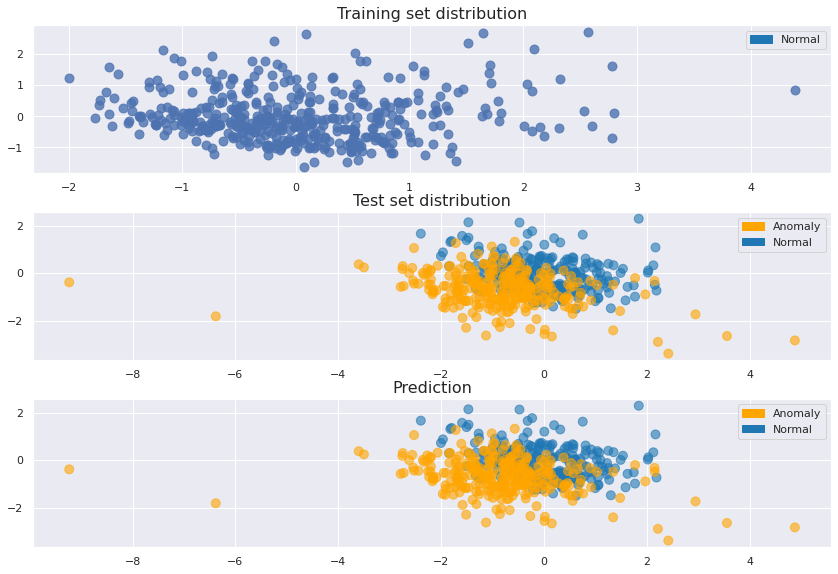

In [ ]:
from sklearn.ensemble import IsolationForest
import matplotlib.patches as mpatches

orange_patch = mpatches.Patch(color='orange', label='Anomaly') # legenda dos plots
blue_patch = mpatches.Patch(color='tab:blue', label='Normal')

training_set = dataset[:450] # apenas exemplos da classe normal no set de treino
test_set = dataset[450:] # exemplos restantes no teste
test_labels = [0]*250 + [1]*(len(test_set)-250) # rotular os primeiros 250 exemplos do teste como 'normais' (sequencias <700).

# Apply PCA
pca = PCA(n_components=4)
pca_train = pca.fit_transform(training_set)
pca_test = pca.transform(test_set)

# Train classifier and perform predictions
model = IsolationForest(random_state=42,contamination=0.01,bootstrap=True,n_estimators=100).fit(training_set)
pred = model.predict(test_set)
pred = [1 if item == -1 else 0 for item in pred]

# Evaluate results
acc_if = accuracy_score(test_labels,pred)
f1_if = f1_score(test_labels,pred)
precision_if = precision_score(test_labels,pred)
recall_if = recall_score(test_labels,pred)
print("Acc: {}| F1: {} | Precision: {} | Recall: {}".format(acc_if,f1_if,precision_if,recall_if))

# Plots
print("\n2D plots of 4-dimensional data (2 first dimensions):")
fig, (ax,ax2,ax3) = plt.subplots(3,figsize=(12, 8))
fig.tight_layout()
ax.scatter(pca_train[:,0],pca_train[:,1],s=80,label='Train',alpha=0.8)
ax.legend(handles=[blue_patch])
ax.set_title("Training set distribution",fontsize=16)

ax2.scatter(pca_test[:,0],pca_test[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in test_labels],alpha=0.6)
ax2.legend(handles=[orange_patch,blue_patch])
ax2.set_title("Test set distribution",fontsize=16)

ax3.scatter(pca_test[:,0],pca_test[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in pred],alpha=0.6)
ax3.legend(handles=[orange_patch,blue_patch])
ax3.set_title("Prediction",fontsize=16)

## One-class SVM:

One-class SVM é um algoritmo para detecção de anomalia, mais especificamente *novelty detection*, caso em que o set de treino possui apenas exemplos "normais". Como um SVM comum, o algoritmo define uma fronteira representando a distribuição normal dos dados.

O parâmetro *nu* (0,1] corresponde a margem do SVM, e indica a probabilidade de encontrar uma observação nova, porém regular, fora da fronteira definida. Resultados ótimos foram obtidos com valores baixos de *nu*.

Acc: 0.9419475655430711| F1: 0.9462738301559792 | Precision: 0.931740614334471 | Recall: 0.9612676056338029


Text(0.5, 1.0, 'Prediction')

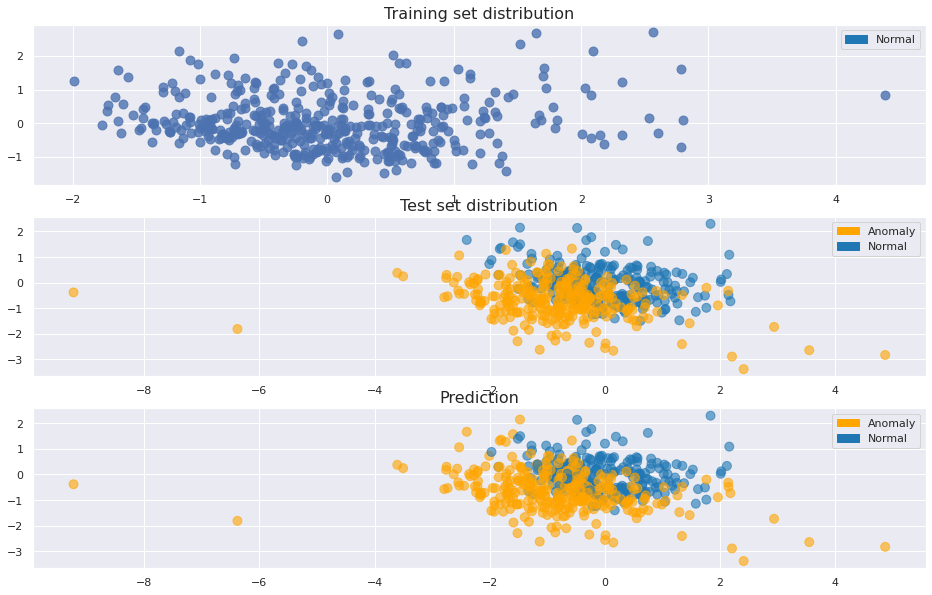

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import f1_score,accuracy_score,precision_score,recall_score
import matplotlib.patches as mpatches

orange_patch = mpatches.Patch(color='orange', label='Anomaly')
blue_patch = mpatches.Patch(color='tab:blue', label='Normal')


# Split dataset
training_set = dataset[:450] # apenas exemplos da classe normal no set de treino
test_set = dataset[450:] # exemplos restantes no teste
test_labels = [0]*250 + [1]*(len(test_set)-250) # rotular os primeiros 250 exemplos do teste como 'normais' (sequencias <700).

# Apply PCA
pca = PCA(n_components=2)
pca_train = pca.fit_transform(training_set)
pca_test = pca.transform(test_set)

# Train classifier and make predictions
model = OneClassSVM(gamma='auto',kernel='rbf',nu=0.03).fit(training_set)
pred = model.predict(test_set)
pred = [1 if item == -1 else 0 for item in pred] # turn prediction of outliers (-1) to 1, in order to apply sklearn metrics.

# Evaluation metrics
acc_ocsvm = accuracy_score(test_labels,pred)
f1_ocsvm = f1_score(test_labels,pred)
precision_ocsvm = precision_score(test_labels,pred)
recall_ocsvm = recall_score(test_labels,pred)
print("Acc: {}| F1: {} | Precision: {} | Recall: {}".format(acc_ocsvm,f1_ocsvm,precision_ocsvm,recall_ocsvm))

# Plots
fig, (ax,ax2,ax3) = plt.subplots(3,figsize=(16, 10))
ax.scatter(pca_train[:,0],pca_train[:,1],s=80,label='Train',alpha=0.8)
ax.legend(handles=[blue_patch])
ax.set_title("Training set distribution",fontsize=16)

ax2.scatter(pca_test[:,0],pca_test[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in test_labels],alpha=0.6)
ax2.legend(handles=[orange_patch,blue_patch])
ax2.set_title("Test set distribution",fontsize=16)

ax3.scatter(pca_test[:,0],pca_test[:,1],s=80,c=['orange' if item == 1 else 'tab:blue' for item in pred],alpha=0.6)
ax3.legend(handles=[orange_patch,blue_patch])
ax3.set_title("Prediction",fontsize=16)

## 4. Visualize model results:

Text(0.5, 1.0, 'Recall')

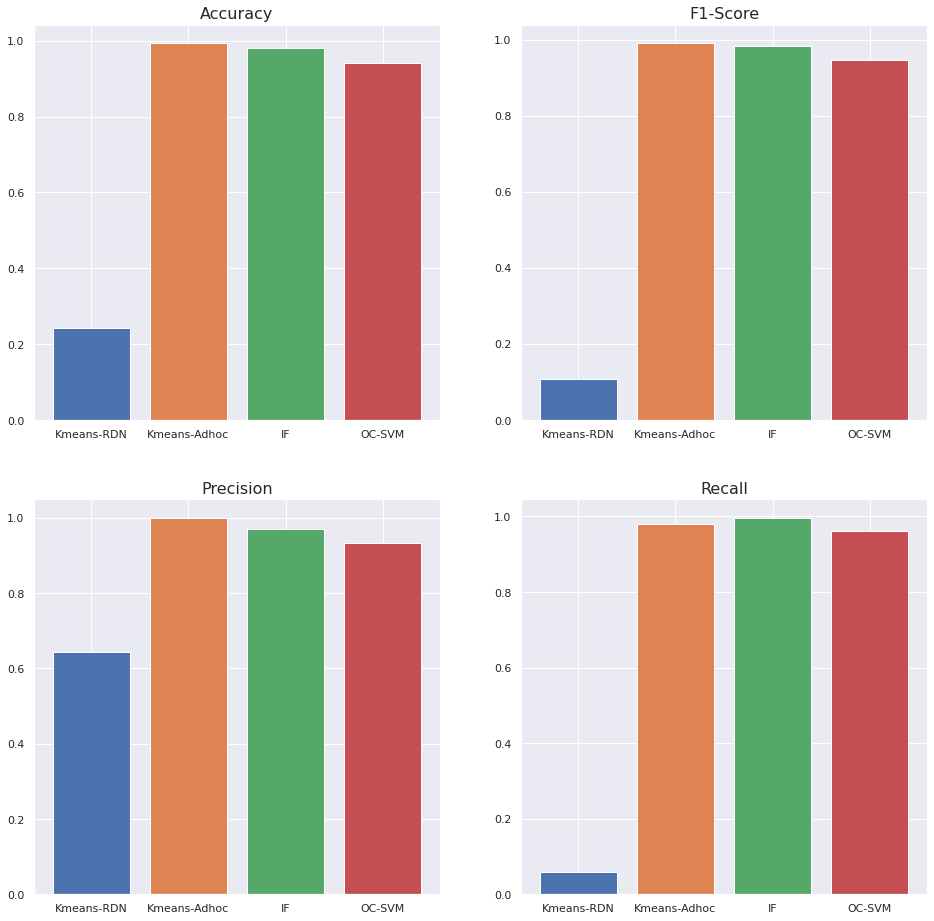

In [ ]:
xlabels = ['Kmeans-RDN','Kmeans-Adhoc', 'IF', 'OC-SVM']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(16,16))
ax1.bar(0,acc_kmeans_rdn)
ax1.bar(1,acc_kmeans_adhoc)
ax1.bar(2,acc_if)
ax1.bar(3,acc_ocsvm)
ax1.set_xticks(range(4))
ax1.set_xticklabels(xlabels)
ax1.set_title('Accuracy',fontsize=16)

ax2.bar(0,f1_kmeans_rdn)
ax2.bar(1,f1_kmeans_adhoc)
ax2.bar(2,f1_if)
ax2.bar(3,f1_ocsvm)
ax2.set_xticks(range(4))
ax2.set_xticklabels(xlabels)
ax2.set_title('F1-Score',fontsize=16)

ax3.bar(0,precision_kmeans_rdn)
ax3.bar(1,precision_kmeans_adhoc)
ax3.bar(2,precision_if)
ax3.bar(3,precision_ocsvm)
ax3.set_xticks(range(4))
ax3.set_xticklabels(xlabels)
ax3.set_title('Precision',fontsize=16)

ax4.bar(0,recall_kmeans_rdn)
ax4.bar(1,recall_kmeans_adhoc)
ax4.bar(2,recall_if)
ax4.bar(3,recall_ocsvm)
ax4.set_xticks(range(4))
ax4.set_xticklabels(xlabels)
ax4.set_title('Recall',fontsize=16)